In [207]:
#Imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math

**Adding Public Bank holiday as dummies**

It will be worth adding the most imporant day off summarize in this website which are likely to have a very different energy load pattern. It must be done by hand on a csv.
https://www.gov.uk/bank-holidays

They are two different types of holidays, the one planned in avance (christmas, easter,...) and the one depending of the ear (university break).

#bank_holiday = pd.read_csv('bank_holiday.csv')
#left join of fulldf with creation of dummies "bank holidays"

In [208]:
#importing of datasets
load = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "load", index_col = 0)
temp = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "historical temperature", index_col = 0)
sun = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "sunshine duration", index_col = 0)
covid = pd.read_csv("covid-stringency-index.csv")
#cleaning covid datset: 
coviduk = covid[covid['Entity']== 'United Kingdom' ]
coviduk = coviduk.set_index('Date')
#join covid with sun dataset
sun_covid = sun.join(coviduk, lsuffix='_caller', rsuffix='_other')
sun_covid = sun_covid.drop(columns=['Entity', 'Code'])
#replace NaN with 0 (i.e. no covid means 0 stringency index)
sun_covid['stringency_index'] = sun_covid['stringency_index'].fillna(0)
#drop column in temp
temp = temp.drop(columns=['Unnamed: 4', '(every 6 hours - 6am/12/6pm/24)'])
#rename column in load
load.columns = ['value']
#rename column in temp
temp.columns=['London', 'Leeds', 'Bristol']

In [209]:
#weighted averate 
#population per city: 
london = 8982000
leeds = 792525
bristol = 467099
total = london + leeds + bristol
london = london/total
leeds = leeds/total
bristol = bristol/total
#weighted average for sun 
L = []
for i, bris in enumerate(sun_covid['Bristol']): 
    avg = bris*bristol + sun_covid['Leeds'][i] * leeds + sun_covid['London'][i] * london
    L.append(avg)
sun_covid['avg_sun'] = L

# weighted average temperature
L = []
for i, bris in enumerate(temp['Bristol']): 
    avg = bris*bristol + temp['Leeds'][i] * leeds + temp['London'][i] * london
    L.append(avg)
temp['avg_temp'] = L

#bring temp to day level 
temp=temp.groupby(pd.Grouper(freq="1D")).mean()

#join all tabels to for regression 
fulldf = temp.join(sun_covid, lsuffix='_temp', rsuffix='_sun')
fulldf = fulldf.drop(columns=['London_temp','Leeds_temp','Bristol_temp','London_sun','Leeds_sun','Bristol_sun'])
fulldf = fulldf.join(load)

#replace na with 0 
fulldf = fulldf.fillna(0)

# we reduce the memory of the dataset
fulldf['value'] = fulldf['value'].astype('float32')

#we use a naive froecast for the last prevision of sun light
fulldf['avg_sun'][-1] = fulldf['avg_sun'][-2]

#we use a naive forecast for the last values of the stringency index
fulldf['stringency_index'][-15:] = fulldf['stringency_index'][-16]

percent_training=0.9
n_training = int(len(fulldf) * percent_training)


In [210]:
fulldf['day']=fulldf.index.day

fulldf['weekday'] = fulldf.index.strftime('%w').astype('int16')
fulldf.loc[fulldf.weekday == 0, 'weekday'] = 7 #changing 0-sunday to 7-sunday

fulldf['month']=fulldf.index.month

## ading lag values
# autoregression term for days 1-7, one for 2 weeks and one for 1 month 
fulldf["values-1"] = fulldf["value"].shift()
fulldf["values-2"] = fulldf["value"].shift(periods=2)
fulldf["values-3"] = fulldf["value"].shift(periods=3)
fulldf["values-4"] = fulldf["value"].shift(periods=4)
fulldf["values-5"] = fulldf["value"].shift(periods=5)
fulldf["values-6"] = fulldf["value"].shift(periods=6)
fulldf["values-7"] = fulldf["value"].shift(periods=7)
fulldf["values-14"] = fulldf["value"].shift(periods=14)
fulldf["values-30"] = fulldf["value"].shift(periods=30)
#fulldf["values-365"] = fulldf["value"].shift(periods=365)
fulldf['quadratic'] = fulldf['values-7']**2

#add moving average for three days 
fulldf['moving_avg'] = (fulldf["values-1"]+fulldf["values-2"]+fulldf["values-3"])/3

In [211]:
## Multiplicative index for seasonality
load_week = fulldf[:n_training].groupby('weekday').agg({'value':'mean'})
index_load_week = load_week / load_week.mean()

load_month = fulldf[:n_training].groupby('month').agg({'value':'mean'})
index_load_month = load_month / load_month.mean()

#we add the two multiplicative index to the fulldf dataset
index_load_week.columns = ['weekly_multiplicative_index']
index_load_week = index_load_week.reset_index()

index_load_month.columns = ['annual_multiplicative_index']
index_load_month = index_load_month.reset_index()

index = fulldf.index
fulldf = fulldf.merge(index_load_week, how = 'left', on = 'weekday')
fulldf = fulldf.merge(index_load_month, how = 'left', on = 'month')
fulldf.index = index

## Training the Neural Network

In [212]:
#remove first 30 rows of dataframe since it includes NaN and the last 2 rows as they don't have a value
df_adjusted = fulldf.iloc[30:-2]
df_adjusted = df_adjusted.drop(columns = ['weekday', 'month','day'])


#split dataset
X_train_1, X_test_1, y_train, y_test = train_test_split(df_adjusted.drop(columns=["value"]),df_adjusted.value, test_size = 1-percent_training, shuffle=False)

#scaler_x=preprocessing.MinMaxScaler(feature_range=(-1, 1))
#StandardScaler()
scaler_x=preprocessing.RobustScaler()

X_train=scaler_x.fit_transform(X_train_1.values)
X_test=scaler_x.transform(X_test_1.values)

X_train = pd.DataFrame(X_train, columns=X_train_1.columns, index=X_train_1.index)
X_test = pd.DataFrame(X_test, columns=X_train_1.columns, index=X_test_1.index)

In [213]:
#run neural network model 
regr = MLPRegressor(hidden_layer_sizes = (112), random_state=1, max_iter=10000).fit(X_train, y_train)

In [214]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(regra, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=X_test.columns.tolist())

Weight,Feature
0.3472 ± 0.1475,weekly_multiplicative_index
0.2631 ± 0.1364,values-1
0.1104 ± 0.0518,quadratic
0.0531 ± 0.2048,avg_temp
0.0342 ± 0.0467,values-7
0.0320 ± 0.0440,values-6
0.0229 ± 0.0633,avg_sun
0.0080 ± 0.0071,values-2
0.0060 ± 0.0042,values-30
-0.0095 ± 0.0280,moving_avg


In [215]:
fulldf2 = fulldf.drop(columns = ['annual_multiplicative_index','values-3','values-4', 'values-5','stringency_index','values-14','moving_avg'])

#remove first 30 rows of dataframe since it includes NaN and the last 2 rows as they don't have a value
df_adjusted = fulldf2.iloc[30:-2]
df_adjusted = df_adjusted.drop(columns = ['weekday', 'month','day'])


#split dataset
X_train_1, X_test_1, y_train, y_test = train_test_split(df_adjusted.drop(columns=["value"]),df_adjusted.value, test_size = 1-percent_training, shuffle=False)

#scaler_x=preprocessing.MinMaxScaler(feature_range=(-1, 1))
#StandardScaler()
scaler_x=preprocessing.RobustScaler()

X_train=scaler_x.fit_transform(X_train_1.values)
X_test=scaler_x.transform(X_test_1.values)

X_train = pd.DataFrame(X_train, columns=X_train_1.columns, index=X_train_1.index)
X_test = pd.DataFrame(X_test, columns=X_train_1.columns, index=X_test_1.index)

In [216]:
#run neural network model 
regr = MLPRegressor(hidden_layer_sizes = (112), random_state=1, max_iter=10000).fit(X_train, y_train)

In [217]:
pred = regr.predict(X_test)
pred=pd.Series(pred,index=y_test.index)

log_pred = np.array([math.log(i) if i>0 else 0 for i in pred])
log_actual = np.array([math.log(i) if i>0 else 0 for i in y_test])

#accuracy of the model 
MSE = mean_squared_error(pred,y_test)
RMSE = math.sqrt(MSE)

log_MSE = mean_squared_error(log_pred, log_actual)
log_RMSE = math.sqrt(log_MSE)

print("Root Mean Square Error:")
print(RMSE)
print("Std:")
print(np.std(pred-y_test)) 

print('\n---------------\n')
print("Root Mean Square Error for log values:")
print(log_RMSE)
print("Std of the log values:")
print(np.std(log_pred-log_actual)) 

Root Mean Square Error:
2045.5419866085997
Std:
1906.6085369589912

---------------

Root Mean Square Error for log values:
0.07401400831021454
Std of the log values:
0.06901389550253931


Text(0, 0.5, 'prediction')

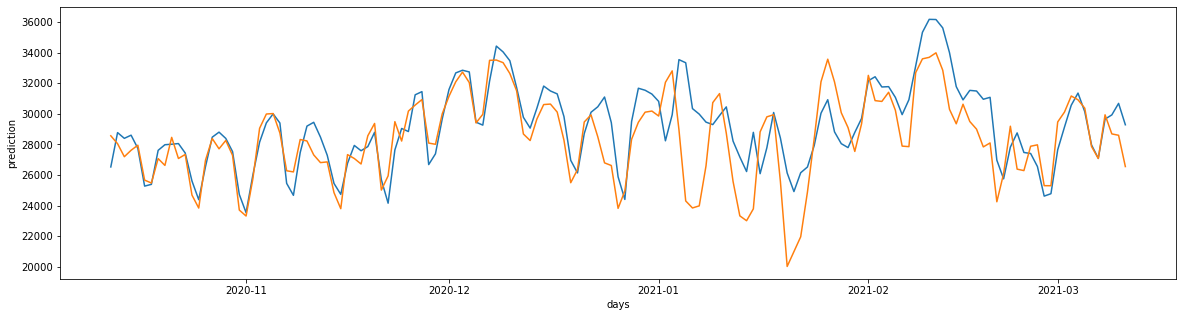

In [223]:
#plot real values 
plt.figure(figsize = (20,5))
plt.plot(pred)
plt.plot(y_test)
plt.xlabel("days")
plt.ylabel("prediction")

In [219]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regr, X_test, y_test,n_repeats=30,random_state=1)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{fulldf.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

values-10.611 +/- 0.080
weekday 0.528 +/- 0.063
avg_sun 0.342 +/- 0.045
avg_temp0.234 +/- 0.063
values-20.138 +/- 0.038
month   0.034 +/- 0.010


In [220]:
from sklearn.feature_selection import SelectFromModel

# It is possible to combine SelectFromModel and
# PermutationImportance directly, without fitting
# PermutationImportance first:
sel = SelectFromModel(PermutationImportance(MLPRegressor(), cv=5,scoring='neg_mean_squared_log_error',n_iter=0),threshold=0.05).fit(X_train, y_train)
X_trans = sel.transform(X_train)

TypeError: len() of unsized object